# Reinforcement Learning for Navigation

In [127]:
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import MultiAgentVecEnv

from mlagents_envs.exception import UnityTimeOutException, UnityWorkerInUseException
from mlagents_envs.side_channel.engine_configuration_channel import EngineConfigurationChannel

import torch as th

import os, yaml
import random
import time
import datetime
import numpy as np
import torch as th
from torch import nn

from mlagents_envs.environment import UnityEnvironment
from gym_unity.envs import UnityToMultiGymWrapper 
import wandb
from rlnav.logging import WANDBMonitor, test_model
from rlnav.schedules import linear_schedule
from pathlib import Path
%matplotlib inline 

In [79]:
encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8, dropout=0, dim_feedforward=512)
src = th.rand(32, 1, 512)
# src = src.view(32,1,512)
out = encoder_layer(src)
out.shape

torch.Size([32, 1, 512])

In [2]:
class CustomNetwork(nn.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        hidden_dim: int = 1024,
        n_layers: int = 2,
        squash_output: bool = False,
    ):
        super(CustomNetwork, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.squash_output = squash_output
        self.hidden_dim = hidden_dim
        self.isCritic = output_dim > 0 
        
        self.model = self.create_model()

    def create_model(self):
        self.depthmask = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=128, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(7),
        ) 

        self.occupancy= nn.Sequential(
            nn.Conv3d(in_channels=1, out_channels=128, kernel_size=3, stride=1, padding=2), nn.ReLU(),
            nn.Conv3d(128, 128, kernel_size=3, padding=2), nn.ReLU(),
            nn.MaxPool3d(5),
        )

        vector_input = 54 if self.isCritic else 51
        self.vector = nn.Sequential(
            nn.Linear(vector_input, self.hidden_dim), nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim), nn.ReLU(),
        )

        total_size = 467 if self.isCritic else 464
        model_list =[
            nn.Linear(total_size, self.hidden_dim), nn.ReLU(),
        ]
        if self.output_dim > 0:
            model_list.append(nn.Linear(self.hidden_dim, self.output_dim))

        if self.squash_output:
            model_list.append(nn.Tanh())

        self.combo_model = nn.Sequential(*model_list)

    def forward(self, input_tensor: th.Tensor) -> th.Tensor:
        vector_obs = th.cat((input_tensor[:, 54], input_tensor[:, -3:])) if self.isCritic else input_tensor[:, 51]
        depth_obs = input_tensor[:, 52:101]
        occupancy = input_tensor[:, 101:-3]  if self.isCritic else input_tensor[:, 101:]
        
        depth_output = th.squeeze(self.depthmask(depth_obs.reshape(-1,1,7,7)))
        occupancy_output = th.squeeze(self.occupancy(occupancy.reshape(-1,1, 11, 3, 11)))
        vector_output = self.vector(vector_obs)
        
        combined_input = th.cat((vector_output, occupancy_output, depth_output), dim=1)
        output = self.combo_model(combined_input)
        return output
    
CustomNetwork(464,3)

CustomNetwork(
  (depthmask): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=7, stride=7, padding=0, dilation=1, ceil_mode=False)
  )
  (occupancy): Sequential(
    (0): Conv3d(1, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
    (2): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(2, 2, 2))
    (3): ReLU()
    (4): MaxPool3d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  )
  (vector): Sequential(
    (0): Linear(in_features=54, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
  )
  (combo_model): Sequential(
    (0): Linear(in_features=467, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=3, bias=True)
  )
)

In [ ]:
class CustomNetwork(nn.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        hidden_dim: int = 1024,
        n_layers: int = 2,
        squash_output: bool = False,
    ):
        super(CustomNetwork, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.squash_output = squash_output
        self.hidden_dim = hidden_dim
        self.isCritic = output_dim > 0 
        
        self.model = self.create_model()

    def create_model(self):
        self.depthmask = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=128, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(7),
        ) 

        self.occupancy= nn.Sequential(
            nn.Conv3d(in_channels=1, out_channels=128, kernel_size=3, stride=1, padding=2), nn.ReLU(),
            nn.Conv3d(128, 128, kernel_size=3, padding=2), nn.ReLU(),
            nn.MaxPool3d(5),
        )

        vector_input = 54 if self.isCritic else 51
        self.vector = nn.Sequential(
            nn.Linear(vector_input, self.hidden_dim), nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim), nn.ReLU(),
        )

        total_size = 467 if self.isCritic else 464
        model_list =[
            nn.Linear(total_size, self.hidden_dim), nn.ReLU(),
        ]
        if self.output_dim > 0:
            model_list.append(nn.Linear(self.hidden_dim, self.output_dim))

        if self.squash_output:
            model_list.append(nn.Tanh())

        self.combo_model = nn.Sequential(*model_list)

    def forward(self, input_tensor: th.Tensor) -> th.Tensor:
        vector_obs = th.cat((input_tensor[:, 54], input_tensor[:, -3:])) if self.isCritic else input_tensor[:, 51]
        depth_obs = input_tensor[:, 52:101]
        occupancy = input_tensor[:, 101:-3]  if self.isCritic else input_tensor[:, 101:]
        
        depth_output = th.squeeze(self.depthmask(depth_obs.reshape(-1,1,7,7)))
        occupancy_output = th.squeeze(self.occupancy(occupancy.reshape(-1,1, 11, 3, 11)))
        vector_output = self.vector(vector_obs)
        
        combined_input = th.cat((vector_output, occupancy_output, depth_output), dim=1)
        output = self.combo_model(combined_input)
        return output
    
CustomNetwork(464,3)

In [5]:
occupancy= nn.Sequential(
            nn.Conv3d(in_channels=1, out_channels=128, kernel_size=3, stride=1, padding=2), nn.ReLU(),
            nn.Conv3d(128, 128, kernel_size=3, padding=2), nn.ReLU(),
            nn.MaxPool3d(kernel_size=(15,5,15)),
#             nn.Flatten()
        )
print(occupancy)

Sequential(
  (0): Conv3d(1, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(2, 2, 2))
  (1): ReLU()
  (2): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(2, 2, 2))
  (3): ReLU()
  (4): MaxPool3d(kernel_size=(15, 5, 15), stride=(15, 5, 15), padding=0, dilation=1, ceil_mode=False)
)


In [6]:
imp = th.tensor(observations.flatten()[0:363*32].reshape(-1, 1, 11,3,11))

NameError: name 'observations' is not defined

In [7]:
occupancy(th.tensor(imp[0:16])).shape

NameError: name 'imp' is not defined

In [8]:
PROTOTYPE_NAME = "JumpV3"
EXPERIMENT_NAME = f"Baseline"
TREATMENT_NAME = "THIS"
ENV_NAME = "BoxSize2_463"
base_bath = Path(fr"C:\Users\batua\Desktop\RLNav\NavigationEnvironments\{PROTOTYPE_NAME}")
ENV_PATH = base_bath / fr"{ENV_NAME}\Env.exe"  

In [4]:
wandb_config = {}
def make_env(rank, seed=0):
  def _init():
    channel = EngineConfigurationChannel()
    unity_env = UnityEnvironment(str(ENV_PATH), base_port=5000 + rank, side_channels=[channel])
    env = UnityToMultiGymWrapper(unity_env)
    env = WANDBMonitor(env, wandb_config, prototype=f"{PROTOTYPE_NAME}", experiment=EXPERIMENT_NAME, treatment=TREATMENT_NAME)
    channel.set_configuration_parameters(time_scale = 5)
    return env
  return _init

env = MultiAgentVecEnv(make_env(512))

NameError: name 'ENV_PATH' is not defined

In [15]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from rlnav.custom_networks import SACCustomPolicy

NotImplementedError: None observation space is not supported

In [128]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\batua\anaconda3\envs\rlnav\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [131]:
# observations = np.load('data/observations.npy')
# actions = np.load('data/actions.npy')
# dones = np.load('data/dones.npy')
# rewards = np.load('data/rewards.npy')

In [132]:
observations = np.load('observation505.npy')
observations = observations.squeeze()

vector_size = 19 + 6
depth_size = 55 - 6
whisker_size = 26 
occupancy_size = 405

vector_end = vector_size
depth_end = vector_end + depth_size
whisker_end = depth_end + whisker_size
occupancy_end = whisker_end + occupancy_size

In [133]:
index = 30

vec_obs = observations[:, 0:vector_end]
depth_obs = observations[:, vector_end:depth_end]
whisker_obs = observations[:, depth_end:whisker_end]
occupancy_obs = observations[:, whisker_end:occupancy_end]

print(vec_obs, whisker_obs, depth_obs, occupancy_obs)
print(vec_obs.shape, whisker_obs.shape, depth_obs.shape, occupancy_obs.shape)
print(vec_obs.shape[0]+ whisker_obs.shape[0]+ depth_obs.shape[0] + occupancy_obs.shape[0])

[[ 1.          0.4094713  -0.1282127  ...  0.          0.
   0.        ]
 [ 1.         -0.39596456  0.08365142 ...  0.          0.
   0.        ]
 [ 0.         -0.20758134  0.0751357  ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]] [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.525349   0.525349   0.525349   ... 0.83398443 0.6764835  0.6764835 ]
 [0.48851925 0.39302602 0.26950708 ... 0.08145189 0.08145189 0.08145189]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]] [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 

### Depthmask

In [134]:
depth_obs.shape

(1000000, 49)

In [135]:
depth_obs.shape
depth_obs_2d = depth_obs.reshape(-1, 1, 7, 7)  ### Occupancy Grid

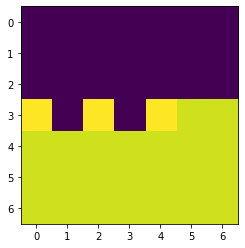

In [141]:
imshow(depth_obs_2d[10, 0])

### Occupancy Grid

In [142]:
occupancy_obs.shape

(1000000, 405)

In [143]:
# z, y, x ordering
occupancy_obs_3d = occupancy_obs.reshape(-1, 1, 5, 3, 5)
occupancy_obs_3d_plt = np.swapaxes(occupancy_obs_3d, -1, -2)
occupancy_obs_3d.shape

(5400000, 1, 5, 3, 5)

In [144]:
occupancy_obs_3d = np.random.uniform(0,1,363*32).reshape(-1, 1, 11, 3, 11)
occupancy_obs_3d.shape

(32, 1, 11, 3, 11)

In [145]:
conv3d_layer = nn.Sequential(
            nn.Conv3d(in_channels=1, out_channels=128, kernel_size=3, stride=1, padding=2), nn.ReLU(),
            nn.Conv3d(128, 128, kernel_size=3, padding=2), nn.ReLU(),
            nn.MaxPool3d(5),
        ).to("cpu")
th.squeeze(conv3d_layer(th.tensor(occupancy_obs_3d[0:16]))).shape

RuntimeError: expected scalar type Double but found Float

In [146]:
occupancy = occupancy_obs_3d[0]
occupancy.shape

(1, 11, 3, 11)

ValueError: Argument filled must be 3-dimensional

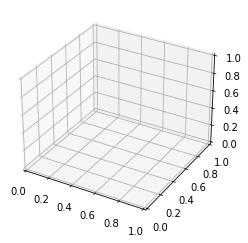

In [147]:
ax = plt.figure().add_subplot(projection='3d')
ax.voxels(occupancy_obs_3d_plt[157])

In [10]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')

In [11]:
class RLNetwork(nn.Module):
    def __init__(self):
        super(RLNetwork, self).__init__()

        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=128, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(),
#           nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(input_size),
        ).to(device)
        
        conv3d_layer = nn.Sequential(
            nn.Conv3d(in_channels=1, out_channels=128, kernel_size=3, stride=1, padding=2), nn.ReLU(),
            nn.Conv3d(128, 128, kernel_size=3, padding=2), nn.ReLU(),
            nn.MaxPool3d(5),
        ).to(device)
        
        self.vector_layer = nn.Sequential(
            nn.Linear(99, 256), nn.ReLU(),
            nn.Linear(256, 256), nn.ReLU(),
        ).to(device)
        
        self.combined_layer = nn.Sequential(
            nn.Linear(256 + 128, 3)).to(device)
        
    def forward(self, features: th.Tensor):
        features.to(device)
        vec_obs = features[:, :99]
        depth_obs = features[:, 99:].reshape(-1, 1, 7, 7)

        vec = self.vector_layer(vec_obs)
        depth = th.squeeze(self.conv_layer(depth_obs))

        merged = th.cat((vec, depth), 1)
        output = self.combined_layer(merged)
        return output

In [12]:
model = RLNetwork()
print(model)

NameError: name 'input_size' is not defined

In [13]:
!pip install torchsummary

In [14]:
from torchsummary import summary

In [15]:
input_size = 7

th.squeeze(conv_layer(th.tensor(depth_obs_2d[:16])))        

NameError: name 'conv_layer' is not defined

In [16]:
in_channels, out_channels, kernel_size, stride=1,
conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1), nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2), nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=1), nn.ReLU(),
            nn.Flatten(),
        )
conv_layer(th.tensor(depth_obs_2d[:16])).shape

ValueError: not enough values to unpack (expected 4, got 1)

In [17]:
from typing import Callable, Dict, List, Optional, Tuple, Type, Union

import gym
import torch as th
from torch import nn

from stable_baselines3 import SAC
from stable_baselines3.common.policies import ActorCriticPolicy


class CustomNetwork(nn.Module):
    """
    Custom network for policy and value function.
    It receives as input the features extracted by the feature extractor.

    :param feature_dim: dimension of the features extracted with the features_extractor (e.g. features from a CNN)
    :param last_layer_dim_pi: (int) number of units for the last layer of the policy network
    :param last_layer_dim_vf: (int) number of units for the last layer of the value network
    """

    def __init__(
        self,
        feature_dim: int,
        last_layer_dim_pi: int = 64,
        last_layer_dim_vf: int = 64,
    ):
        super(CustomNetwork, self).__init__()

        # IMPORTANT:
        # Save output dimensions, used to create the distributions
        self.latent_dim_pi = last_layer_dim_pi
        self.latent_dim_vf = last_layer_dim_vf

        # Policy network
        self.policy_net = nn.Sequential(
            nn.Linear(feature_dim, last_layer_dim_pi), nn.ReLU()
        )
        # Value network
        self.value_net = nn.Sequential(
            nn.Linear(feature_dim, last_layer_dim_vf), nn.ReLU()
        )

    def forward(self, features: th.Tensor) -> Tuple[th.Tensor, th.Tensor]:
        """
        :return: (th.Tensor, th.Tensor) latent_policy, latent_value of the specified network.
            If all layers are shared, then ``latent_policy == latent_value``
        """
        return self.policy_net(features), self.value_net(features)


class CustomActorCriticPolicy(ActorCriticPolicy):
    def __init__(
        self,
        observation_space: gym.spaces.Space,
        action_space: gym.spaces.Space,
        lr_schedule: Callable[[float], float],
        net_arch: Optional[List[Union[int, Dict[str, List[int]]]]] = None,
        activation_fn: Type[nn.Module] = nn.Tanh,
        *args,
        **kwargs,
    ):

        super(CustomActorCriticPolicy, self).__init__(
            observation_space,
            action_space,
            lr_schedule,
            net_arch,
            activation_fn,
            # Pass remaining arguments to base class
            *args,
            **kwargs,
        )
        # Disable orthogonal initialization
        self.ortho_init = False

    def _build_mlp_extractor(self) -> None:
        self.mlp_extractor = CustomNetwork(self.features_dim)


model = PPO(CustomActorCriticPolicy, "CartPole-v1", verbose=1)
model.learn(5000)

NameError: name 'PPO' is not defined